# 11. 심층 신경망 훈련하기

In [2]:
# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)    
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

## 11.1 그레이디언트 소실과 폭주 문제

### 11.1.1 글로럿과 He 초기화

In [3]:
from tensorflow import keras
import tensorflow as tf

keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

### 11.1.2 수렴하지 않는 활성화 함수

In [5]:
keras.layers.Dense(10, kernel_initializer='he_normal')
keras.layers.LeakyReLU(alpha=0.2)

In [6]:
layer = keras.layers.Dense(10, activation='selu', kernel_initializer='lecun_normal')

### 11.1.3 배치 정규화

In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [9]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [10]:
model.layers[1].updates

/var/folders/jd/_tlvgz1d22x3k8jpbtplqcsh0000gn/T/ipykernel_69348/3873162892.py:1: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  model.layers[1].updates


[]

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(10, activation='softmax')
])

### 11.1.4 그레이디언트 클리핑

In [12]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss='mse', optimizer=optimizer)

## 11.2 사전훈련된 층 재사용하기

### 11.2.1 케라스를 사용한 전이 학습

In [13]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [15]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [18]:
tf.random.set_seed(42)
np.random.seed(42)

In [19]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [20]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [21]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.5611 - accuracy: 0.8215 - val_loss: 0.3784 - val_accuracy: 0.8727
Epoch 2/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3452 - accuracy: 0.8844 - val_loss: 0.3185 - val_accuracy: 0.8926
Epoch 3/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3098 - accuracy: 0.8948 - val_loss: 0.2916 - val_accuracy: 0.9008
Epoch 4/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2913 - accuracy: 0.9017 - val_loss: 0.2800 - val_accuracy: 0.9076
Epoch 5/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2788 - accuracy: 0.9057 - val_loss: 0.2694 - val_accuracy: 0.9108
Epoch 6/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2694 - accuracy: 0.9085 - val_loss: 0.2683 - val_accuracy: 0.9053
Epoch 7/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2616 - accuracy: 0.9113 - val_loss: 0.2647 - val_accuracy:

In [22]:
model_A.save("my_model_A.h5")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [26]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [28]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr = 1e-4)

model_B_on_A.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 20ms/step - loss: 0.5086 - accuracy: 0.7250 - val_loss: 0.4305 - val_accuracy: 0.7708
Epoch 2/4
7/7 [==============================] - 0s 6ms/step - loss: 0.3189 - accuracy: 0.8550 - val_loss: 0.3001 - val_accuracy: 0.8682
Epoch 3/4
7/7 [==============================] - 0s 6ms/step - loss: 0.2244 - accuracy: 0.9400 - val_loss: 0.2298 - val_accuracy: 0.9158
Epoch 4/4
7/7 [==============================] - 0s 6ms/step - loss: 0.1724 - accuracy: 0.9700 - val_loss: 0.1853 - val_accuracy: 0.9412


Epoch 1/16
7/7 [==============================] - 0s 20ms/step - loss: 0.0927 - accuracy: 0.9850 - val_loss: 0.0702 - val_accuracy: 0.9817
Epoch 2/16
7/7 [==============================] - 0s 8ms/step - loss: 0.0411 - accuracy: 0.9900 - val_loss: 0.0542 - val_accuracy: 0.9848
Epoch 3/16
7/7 [==============================] - 0s 11ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.0465 - val_accuracy: 0.9858
Epoch 4/16
7/7 [==============================] - 0s 8ms/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.0420 - val_accuracy: 0.9848
Epoch 5/16
7/7 [==============================] - 0s 7ms/step - loss: 0.0183 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.9858
Epoch 6/16
7/7 [==============================] - 0s 7ms/step - loss: 0.0155 - accuracy: 1.0000 - val_loss: 0.0374 - val_accuracy: 0.9868
Epoch 7/16
7/7 [==============================] - 0s 7ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.0375 - val_accuracy: 0.9848
Epoch 8/16
7/7 [================

In [29]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 774us/step - loss: 0.0164 - accuracy: 0.9950


[0.01644645445048809, 0.9950000047683716]

### 11.2.2 비지도 사전훈련

### 11.2.3 보조 작업에서 사전훈련

## 11.3 고속 옵테마이저

### 11.3.1 모멘텀 최적화

In [4]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

### 11.3.2 네스테로프 가속 경사

In [5]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### 11.3.3 AdaGrad

### 11.3.4 RMSProp

In [6]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

### 11.3.5 Adam과 Nadam 최적화

In [7]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1 = 0.9, beta_2=0.999)

### 11.3.6 학습률 스케줄링

## 11.4 규제를 사용해 과대적합 피하기

### 11.4.1 l1과 l2 규제

In [4]:
layer = keras.layers.Dense(100, activation = 'elu', 
                           kernel_initializer='he_normal', 
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [4]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation = 'elu',
                           kernel_initializer = 'he_normal',
                           kernel_regularizer = keras.regularizers.l2(0.01))


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation='softmax', kernel_initializer='glorot_uniform')
])

### 11.4.2 드롭아웃

In [5]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(10, activation='softmax')
])

### 11.4.3 몬테 카를로 드롭아웃

In [13]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [19]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

### 11.4.4 맥스-노름 규제

## 11.5 요약 및 실용적인 가이드라인

## 11.6 연습문제

### 8

#### a

In [4]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'))

#### b

In [5]:
model.add(keras.layers.Dense(10, activation='softmax'))

In [6]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)

model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [8]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170498071/170498071 [==============================] - 280s 2us/step


In [9]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('my_cifar10_model.h5', save_best_only=True)
run_index = 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [16]:
!tensorboard --logdir=./my_cifar10_logs --port=6006

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [18]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 9s 5ms/step - loss: 5.1208 - accuracy: 0.1782 - val_loss: 2.1026 - val_accuracy: 0.2398
Epoch 2/100
  31/1407 [..............................] - ETA: 7s - loss: 2.0473 - accuracy: 0.2500

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 7s 5ms/step - loss: 2.0321 - accuracy: 0.2540 - val_loss: 2.0310 - val_accuracy: 0.2496
Epoch 3/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.9244 - accuracy: 0.2935 - val_loss: 1.9731 - val_accuracy: 0.2812
Epoch 4/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.8412 - accuracy: 0.3275 - val_loss: 1.9701 - val_accuracy: 0.2926
Epoch 5/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.7773 - accuracy: 0.3535 - val_loss: 1.8049 - val_accuracy: 0.3376
Epoch 6/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.7243 - accuracy: 0.3760 - val_loss: 1.7211 - val_accuracy: 0.3786
Epoch 7/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.6766 - accuracy: 0.3945 - val_loss: 1.7781 - val_accuracy: 0.3462
Epoch 8/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.6433 - accuracy: 0.4070 - val_loss: 1.6456 - val_accuracy: 0.39

In [19]:
model = keras.models.load_model('my_cifar10_model.h5')
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 1ms/step - loss: 1.4828 - accuracy: 0.4794


[1.482820987701416, 0.47940000891685486]

#### c

In [30]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(10):
    model.add(keras.layers.Dense(100, kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('elu'))
model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('my_cifar10_bn_model.h5', save_best_only=True)
run_index = 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

model = keras.models.load_model('my_cifar10_bn_model.h5')
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 11s 6ms/step - loss: 1.7513 - accuracy: 0.3743 - val_loss: 1.5846 - val_accuracy: 0.4366
Epoch 2/100
  20/1407 [..............................] - ETA: 7s - loss: 1.5928 - accuracy: 0.4375

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 8s 6ms/step - loss: 1.5787 - accuracy: 0.4396 - val_loss: 1.4861 - val_accuracy: 0.4638
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5076 - accuracy: 0.4649 - val_loss: 1.4569 - val_accuracy: 0.4810
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4577 - accuracy: 0.4816 - val_loss: 1.4629 - val_accuracy: 0.4768
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4113 - accuracy: 0.4994 - val_loss: 1.3841 - val_accuracy: 0.5144
Epoch 6/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3735 - accuracy: 0.5128 - val_loss: 1.3679 - val_accuracy: 0.5156
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3445 - accuracy: 0.5204 - val_loss: 1.3646 - val_accuracy: 0.5102
Epoch 8/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3154 - accuracy: 0.5334 - val_loss: 1.3452 - val_accuracy: 0.52

[1.3001855611801147, 0.5424000024795532]

#### d

In [35]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))
model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('my_cifar10_selu_model.h5', save_best_only=True)
run_index = 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis = 0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks)

model = keras.models.load_model('my_cifar10_selu_model.h5')
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 9s 5ms/step - loss: 1.9244 - accuracy: 0.3135 - val_loss: 1.8595 - val_accuracy: 0.3260
Epoch 2/100
  31/1407 [..............................] - ETA: 7s - loss: 1.7409 - accuracy: 0.3770

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 8s 5ms/step - loss: 1.7110 - accuracy: 0.3948 - val_loss: 1.7837 - val_accuracy: 0.3536
Epoch 3/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.6123 - accuracy: 0.4316 - val_loss: 1.6910 - val_accuracy: 0.3970
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.5380 - accuracy: 0.4547 - val_loss: 1.6119 - val_accuracy: 0.4388
Epoch 5/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4861 - accuracy: 0.4740 - val_loss: 1.6519 - val_accuracy: 0.4264
Epoch 6/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4391 - accuracy: 0.4974 - val_loss: 1.5178 - val_accuracy: 0.4628
Epoch 7/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.3958 - accuracy: 0.5100 - val_loss: 1.5185 - val_accuracy: 0.4726
Epoch 8/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3586 - accuracy: 0.5245 - val_loss: 1.4835 - val_accuracy: 0.47

[1.4722172021865845, 0.5148000121116638]

#### e

#### f

In [36]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [44]:
import math

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

352/352 [==============================] - 3s 7ms/step - loss: nan - accuracy: 0.1445


(9.999999747378752e-06,
 9.615227699279785,
 2.6296823024749756,
 3.897990839821952)

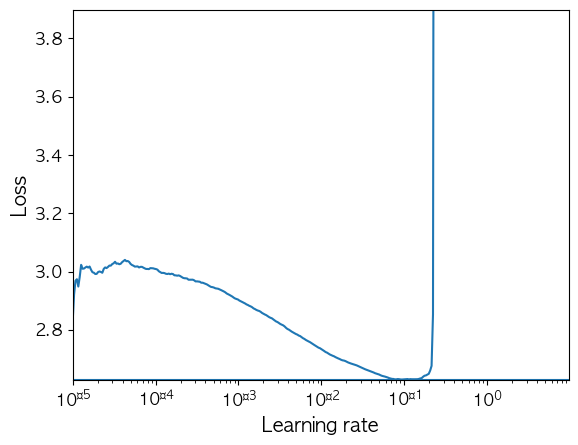

In [45]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [49]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [50]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [51]:
n_epochs = 15
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 9ms/step - loss: 2.0746 - accuracy: 0.2780 - val_loss: 1.8051 - val_accuracy: 0.3692
Epoch 2/15
352/352 [==============================] - 3s 8ms/step - loss: 1.7811 - accuracy: 0.3728 - val_loss: 1.6579 - val_accuracy: 0.4124
Epoch 3/15
352/352 [==============================] - 2s 7ms/step - loss: 1.6342 - accuracy: 0.4189 - val_loss: 1.7531 - val_accuracy: 0.4034
Epoch 4/15
352/352 [==============================] - 2s 7ms/step - loss: 1.5558 - accuracy: 0.4469 - val_loss: 1.6493 - val_accuracy: 0.4356
Epoch 5/15
352/352 [==============================] - 2s 7ms/step - loss: 1.5008 - accuracy: 0.4678 - val_loss: 1.6266 - val_accuracy: 0.4484
Epoch 6/15
352/352 [==============================] - 2s 7ms/step - loss: 1.4589 - accuracy: 0.4828 - val_loss: 1.6462 - val_accuracy: 0.4366
Epoch 7/15
352/352 [==============================] - 2s 7ms/step - loss: 1.4186 - accuracy: 0.4982 - val_loss: 1.6287 - val_accuracy: 0.4458
Epoch 